In [12]:
%load_ext autoreload
%autoreload 2

from src import GP_kernels as gpk
from jax.random import PRNGKey, split
from jax import numpy as jnp
import equinox as eqx
from numpyro.handlers import trace, substitute
from experiments.bayesian_reg.bayesian_regression import bayesian_linear_regression, analytical_mean, analytical_covariance, plot_posterior, get_contours
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal, norm
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from src.utils.miscellaneous import dict_to_namedtuple
from src.utils.trace_dataset import load_traces


means_and_stds = load_traces("experiments/bayesian_reg/means_and_stds.pkl")
means_and_stds = dict_to_namedtuple(means_and_stds)

c = gpk.GPInferenceCfg(
d_model = 128,
dropout_rate = 0.1,
discrete_mlp_width = 512,
discrete_mlp_depth=1,
continuous_flow_blocks=8,
continuous_flow_num_layers_per_block=2,
continuous_flow_num_augment=91,
num_enc_layers=5,
max_discrete_choices =6,
num_input_variables = (1,),
num_observations =6,
means_and_stds=means_and_stds,
)
inference = gpk.GPInference(key=PRNGKey(0),c=c)

inference = eqx.tree_deserialise_leaves("tmp/100k_blr_0005_2.eqx", inference)
inference = eqx.tree_inference(inference, True)

In [14]:
sampler_ = lambda key: bayesian_linear_regression(key, 0.1, 10.0, jnp.arange(6.0)+1)
seed = PRNGKey(888434587)
tr = trace(sampler_).get_trace(key=seed)
obs = tr['obs']['value']
tr

OrderedDict([('x1',
              {'type': 'sample',
               'name': 'x1',
               'fn': <numpyro.distributions.continuous.Normal at 0x7facd0272280>,
               'args': (),
               'kwargs': {'rng_key': Array([3718023120, 2344842080], dtype=uint32),
                'sample_shape': ()},
               'value': Array(-2.4304032, dtype=float32),
               'scale': None,
               'is_observed': False,
               'intermediates': [],
               'cond_indep_stack': [],
               'infer': {}}),
             ('x2',
              {'type': 'sample',
               'name': 'x2',
               'fn': <numpyro.distributions.continuous.Normal at 0x7facd0272700>,
               'args': (),
               'kwargs': {'rng_key': Array([1386582471, 3768030610], dtype=uint32),
                'sample_shape': ()},
               'value': Array(-1.651469, dtype=float32),
               'scale': None,
               'is_observed': False,
               'interm

In [15]:
samples = [inference.rsample(obs,sampler_,PRNGKey(i+7777843))[0] for i in tqdm(range(500))]


  0%|          | 0/500 [00:00<?, ?it/s]

/home/aldo/miniconda3/envs/tfp-jax/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


In [16]:
sigma = 0.1
alpha = 10.0
mu = analytical_mean(jnp.arange(6.0)+1, obs.reshape(-1), sigma, alpha)
cov = analytical_covariance(jnp.arange(6.0)+1, sigma, alpha)
mu, cov, obs

(array([-1.67259057, -2.42519191]),
 array([[ 0.00866588, -0.00199982],
        [-0.00199982,  0.00057139]]),
 Array([[ -4.037077 ],
        [ -6.6730466],
        [ -8.766282 ],
        [-11.576265 ],
        [-13.642409 ],
        [-16.269663 ]], dtype=float32))

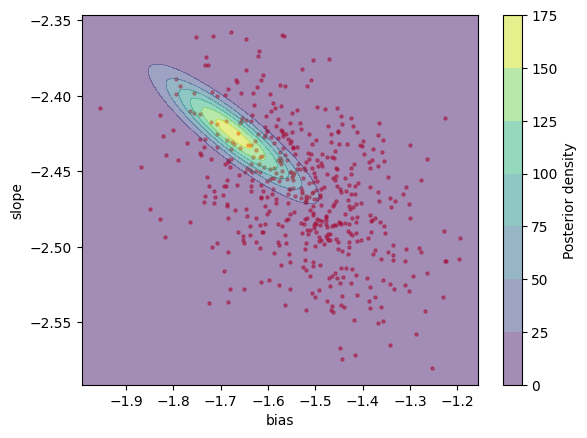

In [17]:
from matplotlib import pyplot as plt
plot_posterior(plt, mu, cov, samples)